In [1]:
import sys

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.insert(0,'/content/drive/MyDrive/nlp_question_answer_project')

    %cd /content/drive/MyDrive/nlp_question_answer_project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/nlp_question_answer_project


In [2]:
%%capture
!pip install -r requirements.txt

# 1.2 Binary Question Classification

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from enum import Enum

import fasttext
import fasttext.util

import torch
from torch import nn
import torch.optim as optim

import torchnlp
import torchnlp.nn

from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from utils.dataset import load_datasets_by_language, save_dataset, load_dataset
from utils.lexical import *

from typing import List, Set, Dict, Tuple, Optional

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
languages = ["en", "fi", "ja"] # Languages which will actually be used.

In [6]:
language_code_to_language = { "en": "english", "fi": "finnish", "ja": "japanese" }
language_models = { "en": {}, "fi": {}, "ja": {} } # here we store all the models for each of the 3 languages

In [7]:
path_to_training_set   = "data/training_set_stanza.pkl"
path_to_validation_set = "data/validation_set_stanza.pkl"

In [8]:
path_to_raw_training_set   = "data/raw_training_set.pkl"
path_to_raw_validation_set = "data/raw_validation_set.pkl"

Load pre-processed data from memory.

In [9]:
all_datasets = load_datasets_by_language(path_to_training_set, path_to_validation_set)

## Feature Exploration
### Distributions over the number of words

In [10]:
def plot_document_token_count_dist(dataset: pd.DataFrame, title: str):
    lengths = count_tokens_per_observation(dataset['document'])

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    ax.hist(lengths, bins=300, density=True) # let's use an histogram instead with fixed bins, since there is much variability.
    
    #ticks = np.linspace(min(uniques), max(uniques)+1, 10)
    #ax.set_xticks(ticks)

In [11]:
def plot_question_token_count_dist(dataset: pd.DataFrame, title: str):
    question_lengths = count_tokens_per_observation(dataset['question'])

    uniques, uniques_counts = np.unique(question_lengths, return_counts=True)
    index_sorted = np.argsort(uniques, axis=None)

    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100

    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Number of tokens")

    x = uniques[index_sorted]
    ax.bar(x, uniques_counts_percentage[index_sorted])
    ticks = np.arange(min(uniques), max(uniques)+1, 1)
    ax.set_xticks(ticks)

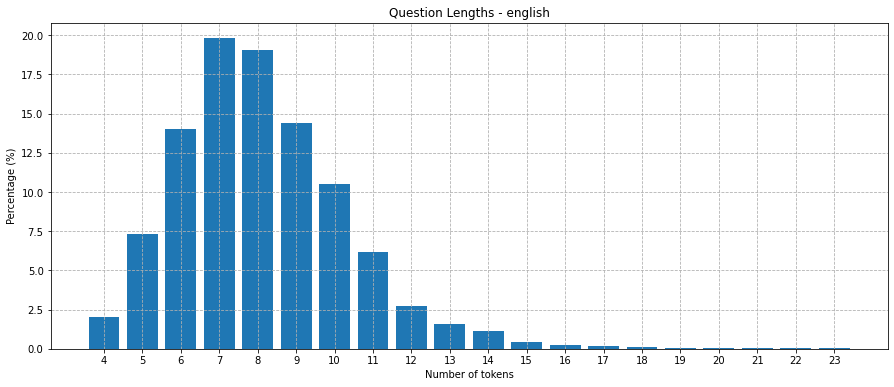

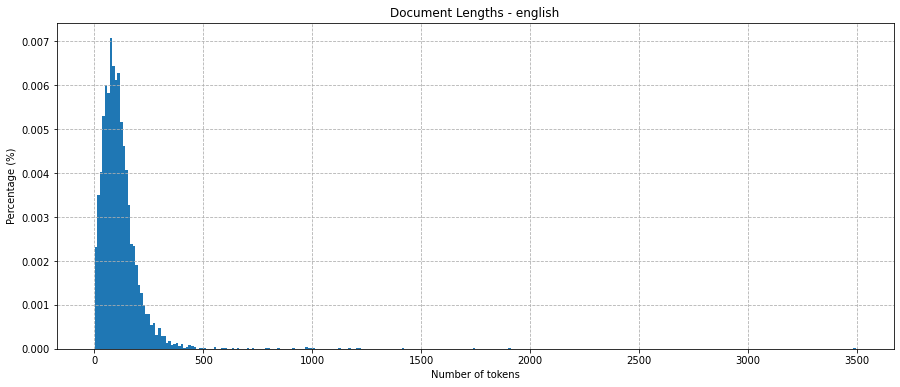

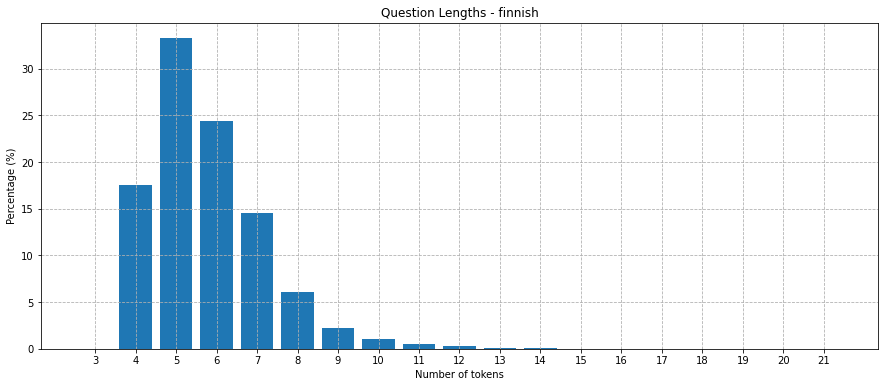

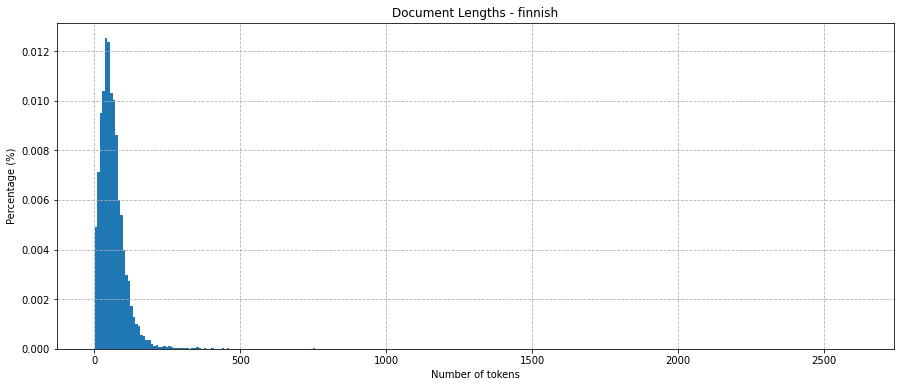

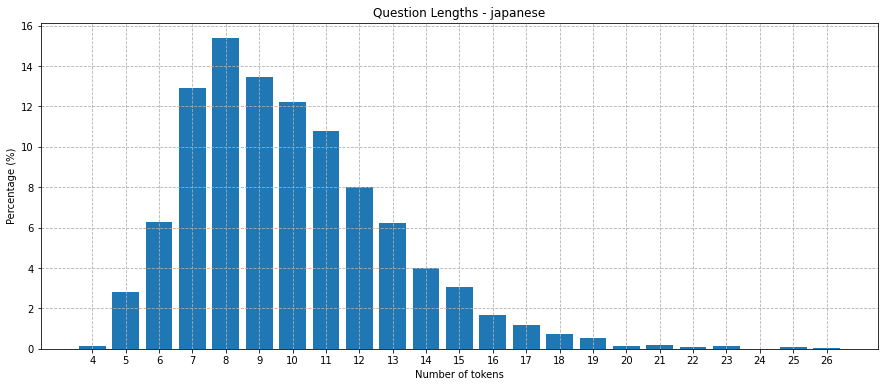

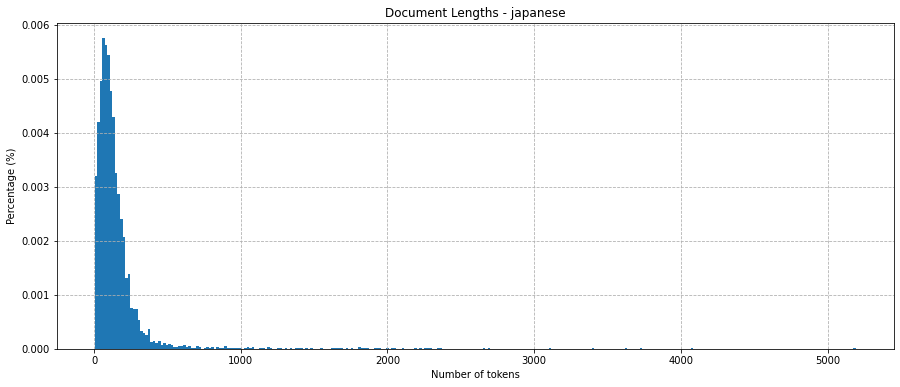

In [12]:
for language in languages:
    dataset = all_datasets[language]
    train_set = dataset["training"]
    validation_set = dataset["validation"]
    language_full = language_code_to_language[language]

    plot_question_token_count_dist(train_set, "Question Lengths - {}".format(language_full))
    plot_document_token_count_dist(train_set, "Document Lengths - {}".format(language_full))

### Features 

@TODO: plot distribution of whether question are answered based on the start word, "How, when, Why" etc

#### Feature Used
- Bag of Words for Question tokens (some words are easier to answer, e.g. When vs How) (also with TF-IDF extension. however, no noticeable change! Actually a bit worse accuracy)
- Number of tokens in document (A longer document is more likely to have the correct answer than a short document)
- Number of tokens in question (A longer answer looks for a very specific answer)
- Answer overlap between document and text

#### Features Ignored
- BoW for the document was not included as part of the features as 1. the memory was on exhausted both on a local machine and cloud machine. 2. BoW is likely a poor feature for question-answer classifiction problems, since this problem needs sentence context, in order to determine whether the question has been answered or not.

## Q1.2a

In [13]:
def str_label_summary(y: np.ndarray) -> str:
    num_answered = np.sum(y == 1)
    num_unanswered = np.sum(y == 0)
    return "Answered questions: {}, unanswered questions: {}.".format(num_answered, num_unanswered)

## Q1.2b+c

In [14]:
def evaluate(label_pred: np.ndarray, label_true: np.ndarray):
    report = classification_report(label_true, label_pred)
    print(report)
    
    cm = confusion_matrix(label_true, label_pred) / len(label_pred) # normalize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [15]:
def run_model(train_set: pd.DataFrame, validation_set: pd.DataFrame):
    token_to_id = create_token_to_id_mapping_from_token_sentences(train_set['question'])
    print("{} unique tokens".format(len(token_to_id)))
    
    X_train = get_lexical_features_from_dataset(train_set, token_to_id)
    y_train = get_labels_from_dataset(train_set)

    X_validation = get_lexical_features_from_dataset(validation_set, token_to_id)
    y_validation = get_labels_from_dataset(validation_set)
    
    print("Train set | " + str_label_summary(y_train))
    print("Validation set | " + str_label_summary(y_validation))

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_validation)
    evaluate(y_preds, y_validation)
    
    return model

Let's do prediction on the validation set for each language and compute the accuracy.

5046 unique tokens
Train set | Answered questions: 3696, unanswered questions: 3693.
Validation set | Answered questions: 495, unanswered questions: 495.
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       495
           1       0.72      0.70      0.71       495

    accuracy                           0.71       990
   macro avg       0.71      0.71      0.71       990
weighted avg       0.71      0.71      0.71       990



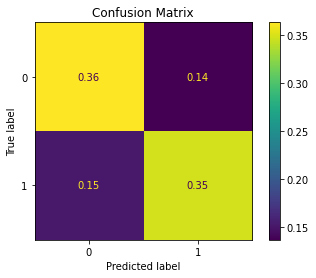

9941 unique tokens
Train set | Answered questions: 6855, unanswered questions: 6846.
Validation set | Answered questions: 843, unanswered questions: 843.
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       843
           1       0.75      0.65      0.70       843

    accuracy                           0.72      1686
   macro avg       0.72      0.72      0.72      1686
weighted avg       0.72      0.72      0.72      1686



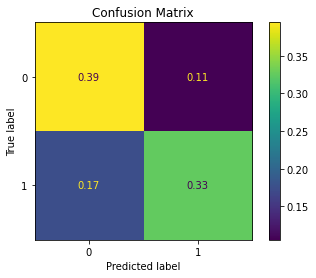

6100 unique tokens
Train set | Answered questions: 4389, unanswered questions: 4389.
Validation set | Answered questions: 518, unanswered questions: 518.
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       518
           1       0.69      0.66      0.68       518

    accuracy                           0.68      1036
   macro avg       0.68      0.68      0.68      1036
weighted avg       0.68      0.68      0.68      1036



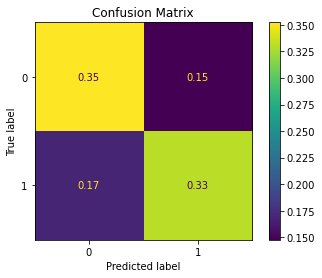

In [16]:
for language in languages:
    dataset = all_datasets[language]
    train_set = dataset["training"]
    validation_set = dataset["validation"]
    language_full = language_code_to_language[language]

    lexical_model = run_model(train_set, validation_set)
    language_models[language]["lexical_model"] = lexical_model

# 2. Representation Learning

In [17]:
def token_to_embedding_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id
        
    return id

In [18]:
def convert_token_to_word_embedding_id(tokens, tok2vec, max_length=-1):
    return [token_to_embedding_id(token, tok2vec) for token in tokens[:max_length]]

In [19]:
def pad_token_ids(token_ids_per_observation: List[List[str]]) -> List[List[str]]:
    assert pad_id != None
    
    token_count_per_observation = [len(token_ids) for token_ids in token_ids_per_observation]
    max_token_count = max(token_count_per_observation)
    
    padded_ids_per_observation = [(token_ids + [pad_id] * (max_token_count - len(token_ids))) for token_ids in token_ids_per_observation]
    
    assert (all(len(padded_ids) == max_token_count for padded_ids in padded_ids_per_observation))
    
    return padded_ids_per_observation

In [20]:
def collate_into_batch(raw_batch):
    """
    Collates a set of observations, where each observation is a list, into a 2d tensor
    """
    question_ids_per_obs        = [obs[0] for obs in raw_batch]
    question_ids_count_per_obs  = [obs[1] for obs in raw_batch]
    question_padded_ids_per_obs = pad_token_ids(question_ids_per_obs)
    
    document_ids_per_obs        = [obs[2] for obs in raw_batch]
    document_ids_count_per_obs  = [obs[3] for obs in raw_batch]
    document_padded_ids_per_obs = pad_token_ids(document_ids_per_obs)
    
    labels = [obs[4] for obs in raw_batch]

    # to tensors
    question_padded_ids_per_obs = torch.tensor(question_padded_ids_per_obs)
    question_ids_count_per_obs = torch.tensor(question_ids_count_per_obs, dtype=torch.long)
    document_padded_ids_per_obs = torch.tensor(document_padded_ids_per_obs)
    document_ids_count_per_obs = torch.tensor(document_ids_count_per_obs, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return question_padded_ids_per_obs, question_ids_count_per_obs, document_padded_ids_per_obs, document_ids_count_per_obs, labels

## Q2A
This question is answered after Q2B actually.

## Q2b

In [21]:
class IsQuestionAnsweredDataset(Dataset):
    
    def __init__(self, dataset, tok2vec):
        self.dataset = dataset
        self.tok2vec = tok2vec
        self.labels = get_labels_from_dataset(dataset)
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.values[idx]

        question_tokens = row[1]
        document_tokens = row[3]
        
        question_ids = convert_token_to_word_embedding_id(question_tokens, tok2vec, 128)
        document_ids = convert_token_to_word_embedding_id(document_tokens, tok2vec, 1024)
        
        labels = self.labels[idx]
        
        return question_ids, len(question_ids), document_ids, len(document_ids), labels

In [22]:
class FF_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(FF_Network, self).__init__()
        
        self.net = nn.Sequential(
            nn.Embedding.from_pretrained(pretrained_embeddings),
            nn.Flatten(start_dim=-2),
            nn.Linear(pretrained_embeddings.shape[1]*2, 72),
            nn.ReLU(),
            nn.Linear(72, n_classes)
        )
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        return self.net(q_ids)


In [23]:
class LSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(LSTM_Network, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, 72)
        self.relu = nn.ReLU()
        self.linear_out = nn.Linear(72, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        #q_ff_in = torch.max(lstm_out, 1)[0]
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        x = self.linear(ff_in)
        x = self.relu(x)
        logits = self.linear_out(x)

        return logits


In [298]:
class BiLSTM_Network(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(BiLSTM_Network, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.1)

        self.linear1 = nn.Linear(2*2*lstm_dim, 64)
        self.linear_out = nn.Linear(64, n_classes)
        #self.norm1 = nn.BatchNorm1d(64)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.3)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #q_ff_in = torch.max(lstm_out, 1)[0]
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        d_ff_in = torch.max(lstm_out, 1)[0]

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        ff_in = self.relu(ff_in)
        ff_in = self.dropout(ff_in)

        x = self.linear1(ff_in)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.norm1(x)
        
        return self.linear_out(x)

In [299]:
class Attentive_LSTM_Network(nn.Module):

    # @TODO Bi!
    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(Attentive_LSTM_Network, self).__init__()

        self.lstm_and_attention_dim = pretrained_embeddings.shape[1]
        self.n_classes = n_classes

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.q_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_biLSTM = nn.LSTM(pretrained_embeddings.shape[1], self.lstm_and_attention_dim, 1, batch_first=True, bidirectional=False)
        self.doc_attention = torchnlp.nn.Attention(self.lstm_and_attention_dim)
        self.linear = nn.Linear(2*self.lstm_and_attention_dim, n_classes)
        
    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.embedding(q_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(q_embeds, q_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.q_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        #q_ff_in = torch.max(lstm_out, 1)[0] # hidden unit with max value
        q_ff_in = lstm_out[range(lstm_out.shape[0]), (q_lengths-1).long(), :] # last unit

        d_embeds = self.embedding(d_ids)
        lstm_in = nn.utils.rnn.pack_padded_sequence(d_embeds, d_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _hidden = self.doc_biLSTM(lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        d_ff_in, weights = self.doc_attention(q_ff_in[:, None, :], lstm_out)
        d_ff_in = d_ff_in[:,0,:] # only 1 query so extract that

        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        logits = self.linear(ff_in)
        
        return logits

In [300]:
def prepare_embedding_matrix(embed_matrix: np.ndarray):
    embed_dim = embed_matrix.shape[1]
    
    pad_embedding = torch.zeros(embed_dim, dtype=torch.float32)
    OOV_embedding = torch.zeros(embed_dim, dtype=torch.float32)
    
    embed_pre = torch.tensor(embed_matrix, dtype=torch.float32)
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad_embedding, OOV_embedding)), pad_id, OOV_id

In [301]:
def test_forward_pass(model: nn.Module):
    """
    A simple function to quickly debug the net
    """
    # Test the forward pass with dummy data
    q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    q_lengths = torch.tensor([3], dtype=torch.int).to(device)
    d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int).to(device)
    d_lengths = torch.tensor([3], dtype=torch.int).to(device)

    out = model.forward(q, q_lengths, d, d_lengths)

    print("Output shape:", out.size())
    print(f"Output logits:\n{out.cpu().detach().numpy()}")

In [302]:
def summarize_batch(q_ids, q_lengths, d_ids, d_lengths):
    assert pad_id != None

    ### question
    actual_length = torch.sum(q_lengths)
    total_length = np.sum([len(question) for question in q_ids])
    
    print("### Question ###")

    OOV_count = np.sum([torch.sum(question == OOV_id) for question in q_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in q_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))

    ## document
    actual_length = torch.sum(d_lengths)
    total_length = np.sum([len(question) for question in d_ids])
    
    print("\n### Document ###")

    OOV_count = np.sum([torch.sum(ids == OOV_id) for ids in d_ids])
    print("OOV: {}/{} {:.2f}%".format(OOV_count, total_length, OOV_count / total_length * 100.))
    
    pad_count = np.sum([torch.sum(ids == pad_id) for ids in d_ids])
    print("PAD: {}/{} {:.2f}%".format(pad_count, total_length, pad_count / total_length * 100.))   
    

In [303]:
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("resources/fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())
train_dataset = IsQuestionAnsweredDataset(all_datasets["en"]["training"], tok2vec)

In [304]:
def batchify(dataset):
    """Turns a list of samples into a tensor of samples"""
    return collate_into_batch([sample for sample in dataset])

In [305]:
collated = batchify(train_dataset)
q_ids, q_lengths, d_ids, d_lengths, _ = collated

In [306]:
summarize_batch(q_ids, q_lengths, d_ids, d_lengths)

### Question ###
OOV: 5015/169947 2.95%
PAD: 109954/169947 64.70%

### Document ###
OOV: 84749/7566336 1.12%
PAD: 6718604/7566336 88.80%


In [307]:
def transfer_batch(q_ids, q_lengths, d_ids, d_lengths, targets, device):
    q_ids     = q_ids.to(device)
    q_lengths = q_lengths.to(device)
    d_ids     = d_ids.to(device)
    d_lengths = d_lengths.to(device)
    targets   = targets.to(device)
    return q_ids, q_lengths, d_ids, d_lengths, targets     

In [316]:
def train(model: nn.Module, tok2vec, train_data, validation_data, weight_decay, n_epochs = 15, batch_size = 32):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

    # Load dataset
    # train_data.iloc[3690:3700]
    train_dataset = IsQuestionAnsweredDataset(train_data, tok2vec)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_into_batch)

    val_dataset = IsQuestionAnsweredDataset(validation_data, tok2vec)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_into_batch)

    # store improvement per epoch
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):

        ### Training
        model.train()

        # Store batch loss and accuracy
        loss_epoch = []
        accuracy_epoch = []

        batch_pbar = tqdm(train_dataloader)
        for batch in batch_pbar:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(*batch, device)
            
            optimizer.zero_grad()
            
            # training
            outputs = model(q_ids, q_lengths, d_ids, d_lengths)
            loss = loss_fn(outputs, targets)

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()

            # prediction
            predictions = outputs.detach().cpu().max(1)[1]
            accuracy = accuracy_score(targets.detach().cpu(), predictions)

            loss_epoch.append(loss.detach().cpu().item())
            accuracy_epoch.append(accuracy)

            batch_pbar.set_description(f"epoch={epoch+1}/{n_epochs} | loss={loss.item():.2f}, accuracy={accuracy:.2f}")

        train_loss = np.mean(loss_epoch)
        train_losses.append(train_loss)

        train_acc = np.mean(accuracy_epoch)
        train_accuracies.append(train_acc)

        ### Evaluation
        test_acc = evaluate_inplace(model, val_dataloader)
        test_accuracies.append(test_acc)

        print(f"epoch={epoch+1}/{n_epochs} | loss={train_loss:.2f}, train_accuracy={train_acc:.2f}, test_accuracy={test_acc:.2f}")

    print("Finished training.")
    
    return train_losses, train_accuracies, test_accuracies

In [317]:
def evaluate_inplace(model: nn.Module, valid_dl: DataLoader):
    model.eval()

    logits_all = []
    targets_all = []

    with torch.no_grad():
        for batch in valid_dl:
            q_ids, q_lengths, d_ids, d_lengths, targets = transfer_batch(*batch, device)

            logits = model(q_ids, q_lengths, d_ids, d_lengths)

            targets_all.extend(targets.detach().cpu().numpy())

            predictions = logits.max(1)[1].cpu()
            logits_all.extend(predictions)
            
        acc = accuracy_score(logits_all, targets_all)

    return acc

In [318]:
def plot_network_learning(model_name, train_accuracies, test_accuracies, train_losses=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    ax.grid(linestyle="--")
    ax.set_title(model_name)
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")

    epoch_range = np.arange(len(train_accuracies), step=1)
    ax.plot(epoch_range, train_accuracies)
    ax.plot(epoch_range, test_accuracies)
    ax.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    
    ax.set_yticks(np.linspace(0.5, 1, 11))
    ax.set_xticks(epoch_range)
    
    if train_losses != None:
        ax2 = ax.twinx()
        ax2.plot(epoch_range, train_losses, c="g")
        ax2.set_yticks(np.linspace(0, 1, 11))
        ax2.set_ylabel("Loss")
        ax2.legend(["Train Loss"], loc="upper right")

In [319]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [320]:
device

device(type='cuda')

In [321]:
def get_tok2vec(path: str):
    return compress_fasttext.models.CompressedFastTextKeyedVectors.load(path)

In [322]:
def train_embedding_model(language_code, all_datasets, weight_decay=3e-7):
    # Setup Model
    tok2vec = get_tok2vec("resources/fasttext-{}-mini".format(language_code))
    pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

    embedding_model = BiLSTM_Network(pretrained_embeddings)
    embedding_model.to(device)

    print(embedding_model)

    #test_forward_pass(embedding_model)

    language_models[language_code]["embedding_model"] = embedding_model

    train_result = train(embedding_model, tok2vec, all_datasets[language_code]["training"], all_datasets[language_code]["validation"], weight_decay=weight_decay, n_epochs=20)

    return train_result

## English

In [323]:
train_result = train_embedding_model("en", all_datasets)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=2, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


epoch=1/30 | loss=0.73, accuracy=0.38: 100%|██████████| 231/231 [00:12<00:00, 18.63it/s]


epoch=1/30 | loss=0.71, train_accuracy=0.50, test_accuracy=0.50


epoch=2/30 | loss=0.72, accuracy=0.48: 100%|██████████| 231/231 [00:14<00:00, 16.09it/s]


epoch=2/30 | loss=0.70, train_accuracy=0.51, test_accuracy=0.60


epoch=3/30 | loss=0.71, accuracy=0.45: 100%|██████████| 231/231 [00:12<00:00, 18.24it/s]


epoch=3/30 | loss=0.68, train_accuracy=0.57, test_accuracy=0.61


epoch=4/30 | loss=0.69, accuracy=0.55: 100%|██████████| 231/231 [00:12<00:00, 18.53it/s]


epoch=4/30 | loss=0.67, train_accuracy=0.60, test_accuracy=0.63


epoch=5/30 | loss=0.58, accuracy=0.76: 100%|██████████| 231/231 [00:13<00:00, 17.07it/s]


epoch=5/30 | loss=0.67, train_accuracy=0.59, test_accuracy=0.61


epoch=6/30 | loss=0.60, accuracy=0.76: 100%|██████████| 231/231 [00:12<00:00, 18.61it/s]


epoch=6/30 | loss=0.67, train_accuracy=0.59, test_accuracy=0.63


epoch=7/30 | loss=0.59, accuracy=0.72: 100%|██████████| 231/231 [00:12<00:00, 18.91it/s]


epoch=7/30 | loss=0.66, train_accuracy=0.62, test_accuracy=0.61


epoch=8/30 | loss=0.68, accuracy=0.59: 100%|██████████| 231/231 [00:12<00:00, 19.16it/s]


epoch=8/30 | loss=0.64, train_accuracy=0.64, test_accuracy=0.66


epoch=9/30 | loss=0.60, accuracy=0.69: 100%|██████████| 231/231 [00:12<00:00, 19.23it/s]


epoch=9/30 | loss=0.59, train_accuracy=0.69, test_accuracy=0.67


epoch=10/30 | loss=0.74, accuracy=0.69: 100%|██████████| 231/231 [00:11<00:00, 19.49it/s]


epoch=10/30 | loss=0.60, train_accuracy=0.68, test_accuracy=0.65


epoch=11/30 | loss=0.71, accuracy=0.69: 100%|██████████| 231/231 [00:11<00:00, 19.31it/s]


epoch=11/30 | loss=0.57, train_accuracy=0.72, test_accuracy=0.70


epoch=12/30 | loss=0.63, accuracy=0.66: 100%|██████████| 231/231 [00:11<00:00, 19.58it/s]


epoch=12/30 | loss=0.57, train_accuracy=0.72, test_accuracy=0.73


epoch=13/30 | loss=0.46, accuracy=0.79: 100%|██████████| 231/231 [00:11<00:00, 19.26it/s]


epoch=13/30 | loss=0.55, train_accuracy=0.73, test_accuracy=0.74


epoch=14/30 | loss=0.54, accuracy=0.79: 100%|██████████| 231/231 [00:13<00:00, 16.57it/s]


epoch=14/30 | loss=0.53, train_accuracy=0.75, test_accuracy=0.74


epoch=15/30 | loss=0.50, accuracy=0.72: 100%|██████████| 231/231 [00:12<00:00, 19.18it/s]


epoch=15/30 | loss=0.51, train_accuracy=0.76, test_accuracy=0.75


epoch=16/30 | loss=0.66, accuracy=0.55: 100%|██████████| 231/231 [00:12<00:00, 19.14it/s]


epoch=16/30 | loss=0.51, train_accuracy=0.77, test_accuracy=0.74


epoch=17/30 | loss=0.68, accuracy=0.72: 100%|██████████| 231/231 [00:12<00:00, 19.20it/s]


epoch=17/30 | loss=0.52, train_accuracy=0.75, test_accuracy=0.75


epoch=18/30 | loss=0.62, accuracy=0.72: 100%|██████████| 231/231 [00:11<00:00, 19.29it/s]


epoch=18/30 | loss=0.57, train_accuracy=0.71, test_accuracy=0.71


epoch=19/30 | loss=0.45, accuracy=0.90: 100%|██████████| 231/231 [00:12<00:00, 18.45it/s]


epoch=19/30 | loss=0.52, train_accuracy=0.76, test_accuracy=0.76


epoch=20/30 | loss=0.38, accuracy=0.83: 100%|██████████| 231/231 [00:12<00:00, 18.34it/s]


epoch=20/30 | loss=0.47, train_accuracy=0.79, test_accuracy=0.78


epoch=21/30 | loss=0.78, accuracy=0.59: 100%|██████████| 231/231 [00:12<00:00, 18.51it/s]


epoch=21/30 | loss=0.46, train_accuracy=0.80, test_accuracy=0.77


epoch=22/30 | loss=0.61, accuracy=0.69: 100%|██████████| 231/231 [00:12<00:00, 18.71it/s]


epoch=22/30 | loss=0.45, train_accuracy=0.80, test_accuracy=0.78


epoch=23/30 | loss=0.42, accuracy=0.83: 100%|██████████| 231/231 [00:12<00:00, 18.26it/s]


epoch=23/30 | loss=0.46, train_accuracy=0.80, test_accuracy=0.78


epoch=24/30 | loss=0.73, accuracy=0.76: 100%|██████████| 231/231 [00:12<00:00, 18.59it/s]


epoch=24/30 | loss=0.44, train_accuracy=0.81, test_accuracy=0.76


epoch=25/30 | loss=0.26, accuracy=0.93: 100%|██████████| 231/231 [00:12<00:00, 17.82it/s]


epoch=25/30 | loss=0.42, train_accuracy=0.82, test_accuracy=0.78


epoch=26/30 | loss=0.38, accuracy=0.86: 100%|██████████| 231/231 [00:12<00:00, 17.90it/s]


epoch=26/30 | loss=0.41, train_accuracy=0.83, test_accuracy=0.78


epoch=27/30 | loss=0.28, accuracy=0.93: 100%|██████████| 231/231 [00:12<00:00, 18.98it/s]


epoch=27/30 | loss=0.38, train_accuracy=0.84, test_accuracy=0.77


epoch=28/30 | loss=0.34, accuracy=0.86: 100%|██████████| 231/231 [00:11<00:00, 19.40it/s]


epoch=28/30 | loss=0.38, train_accuracy=0.84, test_accuracy=0.77


epoch=29/30 | loss=0.38, accuracy=0.79: 100%|██████████| 231/231 [00:11<00:00, 19.59it/s]


epoch=29/30 | loss=0.39, train_accuracy=0.84, test_accuracy=0.79


epoch=30/30 | loss=0.40, accuracy=0.83: 100%|██████████| 231/231 [00:11<00:00, 19.33it/s]


epoch=30/30 | loss=0.37, train_accuracy=0.85, test_accuracy=0.77
Finished training.


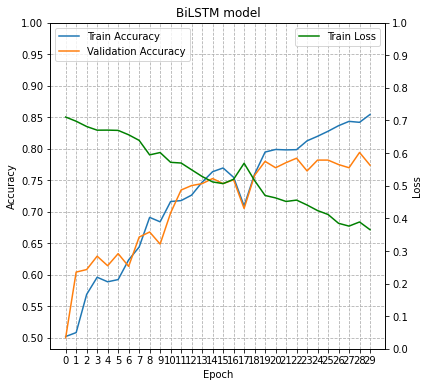

In [324]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("BiLSTM model", train_accuracies, test_accuracies, train_losses)

## Finnish

In [325]:
train_result = train_embedding_model("fi", all_datasets)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=2, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


epoch=1/30 | loss=0.62, accuracy=0.80: 100%|██████████| 429/429 [00:15<00:00, 26.94it/s]


epoch=1/30 | loss=0.69, train_accuracy=0.55, test_accuracy=0.50


epoch=2/30 | loss=0.62, accuracy=0.80: 100%|██████████| 429/429 [00:15<00:00, 27.04it/s]


epoch=2/30 | loss=0.69, train_accuracy=0.57, test_accuracy=0.57


epoch=3/30 | loss=0.79, accuracy=0.20: 100%|██████████| 429/429 [00:15<00:00, 26.93it/s]


epoch=3/30 | loss=0.68, train_accuracy=0.57, test_accuracy=0.57


epoch=4/30 | loss=0.68, accuracy=0.40: 100%|██████████| 429/429 [00:15<00:00, 27.23it/s]


epoch=4/30 | loss=0.68, train_accuracy=0.57, test_accuracy=0.57


epoch=5/30 | loss=0.74, accuracy=0.40: 100%|██████████| 429/429 [00:15<00:00, 27.24it/s]


epoch=5/30 | loss=0.68, train_accuracy=0.58, test_accuracy=0.57


epoch=6/30 | loss=0.66, accuracy=0.60: 100%|██████████| 429/429 [00:18<00:00, 23.74it/s]


epoch=6/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.50


epoch=7/30 | loss=0.75, accuracy=0.20: 100%|██████████| 429/429 [00:16<00:00, 25.78it/s]


epoch=7/30 | loss=0.68, train_accuracy=0.54, test_accuracy=0.57


epoch=8/30 | loss=0.81, accuracy=0.40: 100%|██████████| 429/429 [00:16<00:00, 26.08it/s]


epoch=8/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=9/30 | loss=0.53, accuracy=1.00: 100%|██████████| 429/429 [00:16<00:00, 25.91it/s]


epoch=9/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=10/30 | loss=0.64, accuracy=0.80: 100%|██████████| 429/429 [00:16<00:00, 25.99it/s]


epoch=10/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=11/30 | loss=0.62, accuracy=0.60: 100%|██████████| 429/429 [00:16<00:00, 25.59it/s]


epoch=11/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=12/30 | loss=0.61, accuracy=0.80: 100%|██████████| 429/429 [00:15<00:00, 27.12it/s]


epoch=12/30 | loss=0.67, train_accuracy=0.58, test_accuracy=0.57


epoch=13/30 | loss=0.73, accuracy=0.60: 100%|██████████| 429/429 [00:15<00:00, 27.02it/s]


epoch=13/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.56


epoch=14/30 | loss=0.60, accuracy=0.80: 100%|██████████| 429/429 [00:16<00:00, 26.80it/s]


epoch=14/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=15/30 | loss=0.73, accuracy=0.60: 100%|██████████| 429/429 [00:17<00:00, 24.37it/s]


epoch=15/30 | loss=0.67, train_accuracy=0.56, test_accuracy=0.57


epoch=16/30 | loss=0.56, accuracy=0.80: 100%|██████████| 429/429 [00:15<00:00, 26.94it/s]


epoch=16/30 | loss=0.67, train_accuracy=0.56, test_accuracy=0.58


epoch=17/30 | loss=0.51, accuracy=1.00: 100%|██████████| 429/429 [00:15<00:00, 27.20it/s]


epoch=17/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=18/30 | loss=0.73, accuracy=0.20: 100%|██████████| 429/429 [00:15<00:00, 27.30it/s]


epoch=18/30 | loss=0.66, train_accuracy=0.57, test_accuracy=0.56


epoch=19/30 | loss=0.55, accuracy=1.00: 100%|██████████| 429/429 [00:16<00:00, 26.20it/s]


epoch=19/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.56


epoch=20/30 | loss=0.74, accuracy=0.40: 100%|██████████| 429/429 [00:16<00:00, 26.08it/s]


epoch=20/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.56


epoch=21/30 | loss=0.71, accuracy=0.20: 100%|██████████| 429/429 [00:16<00:00, 25.93it/s]


epoch=21/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.56


epoch=22/30 | loss=0.67, accuracy=0.20: 100%|██████████| 429/429 [00:16<00:00, 26.04it/s]


epoch=22/30 | loss=0.67, train_accuracy=0.58, test_accuracy=0.57


epoch=23/30 | loss=0.65, accuracy=0.60: 100%|██████████| 429/429 [00:16<00:00, 25.74it/s]


epoch=23/30 | loss=0.67, train_accuracy=0.57, test_accuracy=0.57


epoch=24/30 | loss=0.79, accuracy=0.60: 100%|██████████| 429/429 [00:18<00:00, 23.18it/s]


epoch=24/30 | loss=0.67, train_accuracy=0.58, test_accuracy=0.57


epoch=25/30 | loss=0.64, accuracy=0.80: 100%|██████████| 429/429 [00:16<00:00, 26.48it/s]


epoch=25/30 | loss=0.67, train_accuracy=0.58, test_accuracy=0.57


epoch=26/30 | loss=0.70, accuracy=0.40: 100%|██████████| 429/429 [00:15<00:00, 26.98it/s]


epoch=26/30 | loss=0.67, train_accuracy=0.58, test_accuracy=0.58


epoch=27/30 | loss=0.68, accuracy=0.40: 100%|██████████| 429/429 [00:15<00:00, 27.07it/s]


epoch=27/30 | loss=0.68, train_accuracy=0.57, test_accuracy=0.57


epoch=28/30 | loss=0.63, accuracy=0.80: 100%|██████████| 429/429 [00:16<00:00, 26.75it/s]


epoch=28/30 | loss=0.68, train_accuracy=0.58, test_accuracy=0.58


epoch=29/30 | loss=0.65, accuracy=0.40: 100%|██████████| 429/429 [00:15<00:00, 27.13it/s]


epoch=29/30 | loss=0.67, train_accuracy=0.56, test_accuracy=0.56


epoch=30/30 | loss=0.69, accuracy=0.60: 100%|██████████| 429/429 [00:15<00:00, 26.98it/s]


epoch=30/30 | loss=0.67, train_accuracy=0.56, test_accuracy=0.56
Finished training.


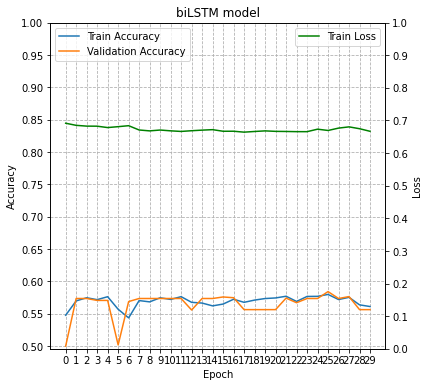

In [326]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("biLSTM model", train_accuracies, test_accuracies, train_losses)

## Japanese

In [327]:
train_result = train_embedding_model("ja", all_datasets)

BiLSTM_Network(
  (embedding): Embedding(20002, 300, padding_idx=20001)
  (biLSTM): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=2, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


epoch=1/30 | loss=0.73, accuracy=0.50: 100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


epoch=1/30 | loss=0.71, train_accuracy=0.50, test_accuracy=0.51


epoch=2/30 | loss=0.68, accuracy=0.60: 100%|██████████| 275/275 [00:22<00:00, 12.50it/s]


epoch=2/30 | loss=0.70, train_accuracy=0.51, test_accuracy=0.50


epoch=3/30 | loss=0.73, accuracy=0.30: 100%|██████████| 275/275 [00:24<00:00, 11.13it/s]


epoch=3/30 | loss=0.70, train_accuracy=0.50, test_accuracy=0.50


epoch=4/30 | loss=0.67, accuracy=0.70: 100%|██████████| 275/275 [00:21<00:00, 12.87it/s]


epoch=4/30 | loss=0.70, train_accuracy=0.49, test_accuracy=0.50


epoch=5/30 | loss=0.71, accuracy=0.40: 100%|██████████| 275/275 [00:20<00:00, 13.64it/s]


epoch=5/30 | loss=0.69, train_accuracy=0.52, test_accuracy=0.56


epoch=6/30 | loss=0.70, accuracy=0.60: 100%|██████████| 275/275 [00:20<00:00, 13.47it/s]


epoch=6/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=7/30 | loss=0.78, accuracy=0.60: 100%|██████████| 275/275 [00:20<00:00, 13.47it/s]


epoch=7/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=8/30 | loss=0.65, accuracy=0.70: 100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


epoch=8/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.56


epoch=9/30 | loss=0.78, accuracy=0.20: 100%|██████████| 275/275 [00:22<00:00, 12.43it/s]


epoch=9/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.50


epoch=10/30 | loss=0.72, accuracy=0.40: 100%|██████████| 275/275 [00:20<00:00, 13.48it/s]


epoch=10/30 | loss=0.68, train_accuracy=0.54, test_accuracy=0.56


epoch=11/30 | loss=0.77, accuracy=0.30: 100%|██████████| 275/275 [00:20<00:00, 13.73it/s]


epoch=11/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.56


epoch=12/30 | loss=0.68, accuracy=0.70: 100%|██████████| 275/275 [00:21<00:00, 12.81it/s]


epoch=12/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=13/30 | loss=0.73, accuracy=0.20: 100%|██████████| 275/275 [00:21<00:00, 13.09it/s]


epoch=13/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=14/30 | loss=0.70, accuracy=0.60: 100%|██████████| 275/275 [00:21<00:00, 13.02it/s]


epoch=14/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.55


epoch=15/30 | loss=0.69, accuracy=0.60: 100%|██████████| 275/275 [00:21<00:00, 13.09it/s]


epoch=15/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=16/30 | loss=0.68, accuracy=0.70: 100%|██████████| 275/275 [00:22<00:00, 12.45it/s]


epoch=16/30 | loss=0.67, train_accuracy=0.56, test_accuracy=0.56


epoch=17/30 | loss=0.66, accuracy=0.50: 100%|██████████| 275/275 [00:20<00:00, 13.39it/s]


epoch=17/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.56


epoch=18/30 | loss=0.67, accuracy=0.60: 100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


epoch=18/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=19/30 | loss=0.71, accuracy=0.40: 100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


epoch=19/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=20/30 | loss=0.66, accuracy=0.30: 100%|██████████| 275/275 [00:20<00:00, 13.48it/s]


epoch=20/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.50


epoch=21/30 | loss=0.62, accuracy=0.70: 100%|██████████| 275/275 [00:20<00:00, 13.14it/s]


epoch=21/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.55


epoch=22/30 | loss=0.65, accuracy=0.70: 100%|██████████| 275/275 [00:20<00:00, 13.27it/s]


epoch=22/30 | loss=0.69, train_accuracy=0.53, test_accuracy=0.52


epoch=23/30 | loss=0.68, accuracy=0.70: 100%|██████████| 275/275 [00:22<00:00, 12.24it/s]


epoch=23/30 | loss=0.69, train_accuracy=0.54, test_accuracy=0.56


epoch=24/30 | loss=0.61, accuracy=0.80: 100%|██████████| 275/275 [00:21<00:00, 13.04it/s]


epoch=24/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=25/30 | loss=0.63, accuracy=0.80: 100%|██████████| 275/275 [00:20<00:00, 13.33it/s]


epoch=25/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=26/30 | loss=0.72, accuracy=0.50: 100%|██████████| 275/275 [00:20<00:00, 13.52it/s]


epoch=26/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=27/30 | loss=0.71, accuracy=0.50: 100%|██████████| 275/275 [00:20<00:00, 13.57it/s]


epoch=27/30 | loss=0.68, train_accuracy=0.56, test_accuracy=0.56


epoch=28/30 | loss=0.67, accuracy=0.70: 100%|██████████| 275/275 [00:20<00:00, 13.38it/s]


epoch=28/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=29/30 | loss=0.71, accuracy=0.60: 100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


epoch=29/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56


epoch=30/30 | loss=0.65, accuracy=0.60: 100%|██████████| 275/275 [00:21<00:00, 12.60it/s]


epoch=30/30 | loss=0.68, train_accuracy=0.55, test_accuracy=0.56
Finished training.


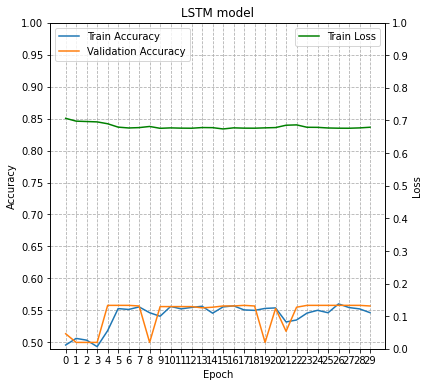

In [328]:
train_losses, train_accuracies, test_accuracies = train_result
plot_network_learning("LSTM model", train_accuracies, test_accuracies, train_losses)

## Q2A

In [329]:
def predict_with_combined_model(lexical_model, embedding_model: nn.Module, token_to_id, dataset, tok2vec):
    
    # Prepare datasets
    X_lexical = get_lexical_features_from_dataset(dataset, token_to_id)

    embedding_dataset = IsQuestionAnsweredDataset(dataset, tok2vec)
    X_embedding = batchify(embedding_dataset)
    
    # Prediction for each
    y_lexical = lexical_model.predict_proba(X_lexical)
    
    embedding_model.eval()
    with torch.no_grad():
        q_ids, q_lengths, d_ids, d_lengths, _ = transfer_batch(*X_embedding, device)
        logits = embedding_model(q_ids, q_lengths, d_ids, d_lengths)
        y_embedding = nn.functional.softmax(logits, dim=1).cpu().numpy()
    
    # Combined prediction
    y_combined = y_lexical * y_embedding
    combined_predictions = y_combined.argmax(axis=1)

    return combined_predictions




### Evaluation for en ###
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       495
           1       0.79      0.78      0.78       495

    accuracy                           0.78       990
   macro avg       0.78      0.78      0.78       990
weighted avg       0.78      0.78      0.78       990



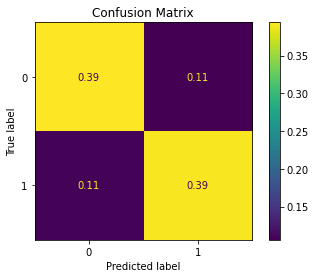




### Evaluation for fi ###
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       843
           1       0.79      0.41      0.54       843

    accuracy                           0.65      1686
   macro avg       0.70      0.65      0.63      1686
weighted avg       0.70      0.65      0.63      1686



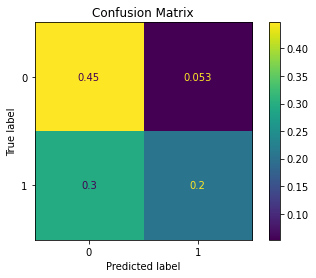




### Evaluation for ja ###
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       518
           1       0.78      0.30      0.44       518

    accuracy                           0.61      1036
   macro avg       0.67      0.61      0.57      1036
weighted avg       0.67      0.61      0.57      1036



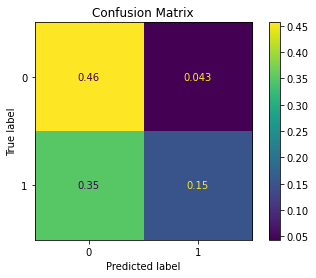

In [331]:
for language in languages:
    train_set = all_datasets[language]["training"]
    validation_set = all_datasets[language]["validation"]
    token_to_id = create_token_to_id_mapping_from_token_sentences(train_set["question"])
    lexical_model = language_models[language]["lexical_model"]
    embedding_model = language_models[language]["embedding_model"]
    tok2vec = get_tok2vec("resources/fasttext-{}-mini".format(language))
    
    y_pred = predict_with_combined_model(lexical_model, embedding_model, token_to_id, validation_set, tok2vec)
    y_true = get_labels_from_dataset(validation_set)

    print("\n\n\n### Evaluation for {} ###".format(language))
    evaluate(y_pred, y_true)